In [ ]:
#O banco de dados consiste em 10000 dados com 10 colunas
#As colunas são representadas por:
#UDI: Identificador da linha - vai de 1 até 10000
#Product ID: Identificador do produto
#Type: Consisste nas letras L, M ou H que servem pra identificar a qualidade do produto
#Air temperature [K] = Temperatura do ar durante o processo
#Process temperature [K] = Temperatura do processo
#Rotational speed [rpm] = Rotações por minuto do processo
#Torque [Nm] = Torque exercido no produto
#Tool Wear [min] = Tempo de uso da peça de fabricação do produto
#O tempo de duração que é adicionado ao Tool Wear depende da qualidade da peça
#H = +5min
#M = +3min
#L = +2min

#Modos de falha
#Tool Wear Failure = Quando a peça é trocada depois de 200 a 240min de trabalho

#Heat Dissipation Failure = Dissipação de calor causa a falha quando a diferença 
#entre o ar e o processo é menor que 8.6K e a rotação esta abaixo de 1380RPM

#Power Failure = O produto do torque pela velocidade angular (rad/s) esta menor 
#que 3500W ou maior que 9000W

#Overstrain Failure = Quando o torque exercido sobre o produto ultrapassa:
#11min para produtos L
#12min para produtos M
#13min para produtos H

#Random failures = 0.1% do processo total.

In [1]:
#INCLUINDO LIBS E LENDO O CSV

import seaborn as sb
import pandas as pd
import numpy as np
from matplotlib import pyplot
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from keras.utils import plot_model
import itertools

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

dB_origin = pd.read_csv('./predictive_maintenance.csv')
dB_origin.head(10)

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure
5,6,M14865,M,298.1,308.6,1425,41.9,11,0,No Failure
6,7,L47186,L,298.1,308.6,1558,42.4,14,0,No Failure
7,8,L47187,L,298.1,308.6,1527,40.2,16,0,No Failure
8,9,M14868,M,298.3,308.7,1667,28.6,18,0,No Failure
9,10,M14869,M,298.5,309.0,1741,28.0,21,0,No Failure


In [2]:
#TRANSFORMANDO A COLUNA CATEGORICA EM NÃO CATEGORICA PELO ONE HOT ENCODER

encoder = OneHotEncoder()
encoder_df = pd.DataFrame(encoder.fit_transform(dB_origin[['Type']]).toarray())
dB_origin = dB_origin.join(encoder_df)

dB_origin.drop(columns='UDI', axis=1, inplace=True)
dB_origin.drop(columns='Failure Type', axis=1, inplace=True)
dB_origin.drop(columns='Product ID', axis=1, inplace=True)
dB_origin.drop(columns='Type', axis=1, inplace=True)

dB_origin.columns=['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Target','Type H','Type L','Type M']

dB_origin.head(1)

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Type H,Type L,Type M
0,298.1,308.6,1551,42.8,0,0,0.0,0.0,1.0


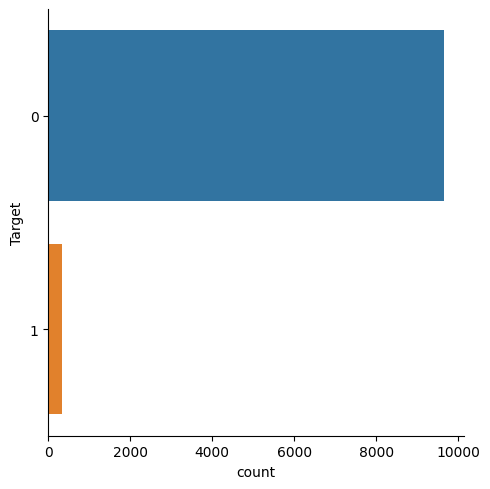

In [72]:
classification = 'Target'

#PARAMETROS DE TREINAMENTO
max_hidden_n = 10
hidden_neurons_act = ['tanh', 'linear', 'relu', 'selu']
my_metric = 'Recall'
my_patience = 350
max_epoch = 20*my_patience
min_improvement = 0.01
min_gain_neuron = 0.005
adam_initial_lr = 0.001
adam_decay_steps = max_epoch
adam_lr_decay = 0.9
rollback_on_no_lower_bound_gain = True
project_name = 'Predictive_Maintenance'

#AJUSTES DO SEED
random_seed = 19
n_k_folds = 5

#SEPARANDO DADOS E PLOTANDO
sb.catplot(data=dB_origin, y=classification, kind='count')

<AxesSubplot:>

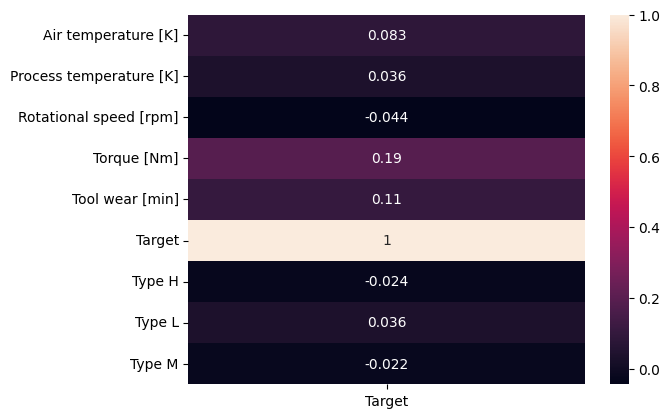

In [4]:
corr = dB_origin.corr()
sb.heatmap(dB_origin.corr()[['Target']], annot=True)

In [5]:
#PARAMETROS DE CLASSIFICAÇÃO
my_vars = list(dB_origin.columns[dB_origin.columns != 'Target'])
print(my_vars)

#DEFININDO MEU OPTIMIZER
optimizer = {'adam': tf.keras.optimizers.Adam(learning_rate=adam_initial_lr)}

#SETANDO O RANDOM SEED
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

#SEPARANDO DATASETS E JOGANDO PRA NUMPY
db_X = dB_origin[my_vars]
db_Y = dB_origin[classification]
X = db_X.to_numpy()
Y = db_Y.to_numpy()

#NORMALIZANDO FEATURES
scaler = StandardScaler()
scaler = scaler.fit(X)
scaled_X = scaler.transform(X)

#INICIANDO K FOLDS
sk_folds = StratifiedKFold(n_splits=n_k_folds)
sk_folds.get_n_splits(scaled_X, Y)

['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Type H', 'Type L', 'Type M']


5

In [58]:
#INICIANDO O TREINAMENTO
best_net_name = None
best_net = None
best_metric = 0.0
best_metric_val = 0.0
lower_bound = 0.0
result_list = []
print('Começando...')

for n_neuron in np.arange(1, max_hidden_n+1):
    ix_fold = 1

    for train_index, test_index in sk_folds.split(scaled_X, Y):
        X_train, X_test = scaled_X[train_index], scaled_X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]

        sm = SMOTE()
        X_bal, Y_bal = sm.fit_resample(X_train, Y_train)

        for activations in hidden_neurons_act:
            inputs = keras.Input(shape=(len(my_vars), ))
            hidden_1 = keras.layers.Dense(3, activation = activations, name = 'Dense_1')(inputs)
            output = keras.layers.Dense(1, activation = 'sigmoid')(hidden_1)
            model_name = project_name
            PdM = keras.Model(inputs = inputs, outputs = output, name = model_name)

            metric_name = my_metric.lower()
            val_metric_name = 'val_{}'.format(metric_name)
            PdM.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=adam_initial_lr), loss='BinaryCrossentropy', metrics=[my_metric])
            es_loss = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = my_patience, restore_best_weights=True)
            es_metric = tf.keras.callbacks.EarlyStopping(monitor = metric_name, mode='max', patience = my_patience, min_delta = min_improvement)
            es_val_metric = tf.keras.callbacks.EarlyStopping(monitor = val_metric_name, mode='max', patience = n_k_folds*my_patience, min_delta = min_improvement)

            class_weight_for_0 = Y_train.shape[0]/(Y_train==0).sum()
            class_weight_for_1 = my_class_weight = Y_train.shape[0]/Y_train.sum()
            class_weights = {0: class_weight_for_0, 1:class_weight_for_1}
            history = PdM.fit(X_train, Y_train, validation_data=(X_test, Y_test), batch_size= X_train.shape[0], epochs=max_epoch, verbose=0, callbacks=[es_loss, es_metric, es_val_metric], class_weight = class_weights)

            model_loss = history.history['loss'][-1]
            model_val_loss = history.history['val_loss'][-1]
            metric_val = history.history[metric_name][-1]
            val_metric_val = history.history[val_metric_name][-1]
            n_epochs = len(history.history['val_loss'])

            best_net_txt=''
            is_best = False
            max_metrics = (val_metric_val == 1.0) & (metric_val == 1.0)
            if max_metrics:
                print('REDE OVERFITADA -> DESCONSIDERADA')
            else:
                if((metric_val > best_metric + min_improvement) & (val_metric_val >= best_metric_val)) | ((metric_val >= best_metric) & (val_metric_val > best_metric_val + min_improvement)):
                    best_net_name = model_name
                    best_metric = metric_val
                    best_metric_val = val_metric_val
                    best_net = PdM
                    best_neurons = n_neuron
                    best_activation = activations
                    best_net_txt = '***SUCESSO***'
                    is_best = True
                    print('FOLD: {}/{} - NEURONIO {}/{}'.format(ix_fold, n_k_folds, n_neuron, max_hidden_n))
                    print('{} - {} -> EPOCHS:{}, {}:{:.2f}%, {}:{:.2f}% {}'.format(model_name, activations, n_epochs, metric_name, 100.0*metric_val, val_metric_name,100.0*val_metric_val, best_net_txt))

            result_dict = {'model_name': model_name, 'optimizer': 'Adam', 'neurons': n_neuron, 'fold': ix_fold, 'loss': model_loss, 
            'val_loss': model_val_loss, metric_name: metric_val, val_metric_name: val_metric_val, 'epochs': n_epochs, 'is_best': is_best, 'net': PdM, 'activation': activations}

            result_list.append(result_dict)
                    
        ix_fold += 1
        
      
    nao_precisa_mais_neuronios = False
    if n_neuron > 1:
        if best_neurons < n_neuron:
            nao_precisa_mais_neuronios = True
            print('Rede com {} nao aumentaram a {}'.format(n_neuron, metric_name))
            break
    
    df_results = pd.DataFrame(result_list)
    df_results.drop(df_results.index[df_results[val_metric_name] == df_results[df_results.neurons == n_neuron][val_metric_name].min()], inplace=True)
    pior_resultado = df_results[df_results.neurons == n_neuron][val_metric_name].min()

    pior_resultado_nao_melhora = False
    if n_neuron > 1:
        neuron_gain = 0.0
        if pior_resultado > lower_bound:
            if lower_bound > 0.0:
                neuron_gain = pior_resultado / lower_bound - 1.0
                if neuron_gain < min_gain_neuron:
                    print('REDES COM {} NEURONIOS NÃO MELHORARAM MAIS QUE O MENOR INDICE {} {:.1f} GANHO DO NEURONIO {:.1f} / MIN {:.1f}'.format(n_neuron, val_metric_name, 100.0*pior_resultado, 100.0*neuron_gain))
                    pior_resultado_nao_melhora = True
                    break
                else:
                    print ('GANHO DA REDE COM {} NEURONIOS: {:.1f} >> {:.1f} = {:.2f}'.format(n_neuron, 100.0*lower_bound, 100.0*pior_resultado, 100.0*neuron_gain))
            else:
                print('REDE COM GANHOS DE 0.0 >> {:.1f}'.format(100.0*pior_resultado))
        else:
            print('SEM GANHO COM {} NEURONIOS PARA {}: {:.1f} >> {:.1f}'.format(n_neuron, 'Adam', 100.0*lower_bound, 100.0*pior_resultado))
            pior_resultado_nao_melhora = True
            break
    else:
        print('GANHO MINIMO ESTIMADO PARA {} NEURONIOS: {:.1f}%'.format(n_neuron+1, 100.0*pior_resultado))

    lower_bound = pior_resultado
    print('')
    if max_metrics or nao_precisa_mais_neuronios:
        break


Começando...
FOLD: 1/5 - NEURONIO 1/10
Predictive_Maintenance - tanh -> EPOCHS:301, recall:83.46%, val_recall:74.63% ***SUCESSO***
FOLD: 2/5 - NEURONIO 1/10
Predictive_Maintenance - tanh -> EPOCHS:440, recall:85.24%, val_recall:83.82% ***SUCESSO***
FOLD: 3/5 - NEURONIO 1/10
Predictive_Maintenance - relu -> EPOCHS:301, recall:85.98%, val_recall:98.53% ***SUCESSO***
GANHO MINIMO ESTIMADO PARA 2 NEURONIOS: 55.9%

Rede com 2 nao aumentaram a recall


In [59]:
if pior_resultado_nao_melhora or nao_precisa_mais_neuronios:
    best_row_baseline = df_results[(df_results.neurons == 1) & df_results.is_best].tail(1)
    best_net_name = best_row_baseline['model_name'].values[0]
    best_optimizer = best_row_baseline['optimizer'].values[0]
    best_net = best_row_baseline['net'].values[0]
    best_neurons = best_row_baseline['neurons'].values[0]
    best_metric = best_row_baseline[metric_name].values[0]
    best_metric_val = best_row_baseline[val_metric_name].values[0]
    best_loss = best_row_baseline['loss']
    best_val_loss = best_row_baseline['val_loss']
    best_epochs = best_row_baseline['epochs']
    best_activation = best_row_baseline['activation'].values[0]

Predictive_Maintenance -> QTD DE NEURONIOS: 1 / FUNÇÃO DE ATIVAÇÃO


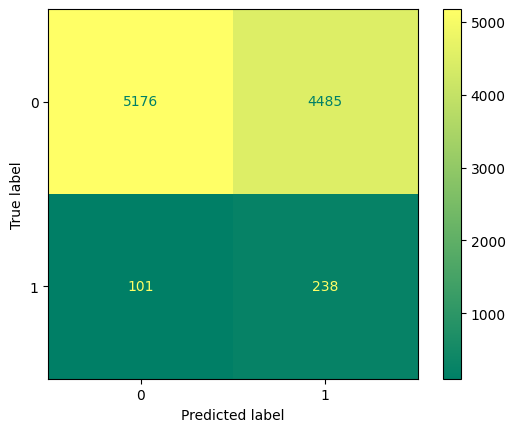

In [60]:
#CRIANDO MATRIZ DE CONFUSÃO
Y_predict = best_net.predict(scaled_X, verbose = 0)
Y_predict_array = np.empty(len(Y_predict), dtype = int)
for i in range(0, len(Y_predict)):
    if Y_predict[i] >= 0.5:
        Y_predict_array[i] = 1
    else:
        Y_predict_array[i] = 0

Y_list = Y.tolist()
Y_predict_list = Y_predict_array.tolist()
      
cm = confusion_matrix(Y_list, Y_predict_list, labels=[0,1])
disp = ConfusionMatrixDisplay(cm, display_labels=[0,1])
print('{} -> QTD DE NEURONIOS: {} / FUNÇÃO DE ATIVAÇÃO'.format(best_net_name, best_neurons))
disp.plot(cmap = 'summer')

In [21]:
#REDE COM 2 HIDDEN

#INICIANDO O TREINAMENTO
best_net_name = None
best_net = None
best_metric = 0.0
best_metric_val = 0.0
lower_bound = 0.0
hidden_act_aux = 0
result_list = []
neurons_list = []
print('Começando...')

for n_neuron in np.arange(1, max_hidden_n+1):
    ix_fold = 1
    neurons_list.append(n_neuron)
    for train_index, test_index in sk_folds.split(scaled_X, Y):
        X_train, X_test = scaled_X[train_index], scaled_X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]

        sm = SMOTE()
        X_bal, Y_bal = sm.fit_resample(X_train, Y_train)

        for activations in hidden_neurons_act:
            for n_hidden_neuron in range(1,len(neurons_list)+1):
                inputs = keras.Input(shape=(len(my_vars), ))
                hidden_1 = keras.layers.Dense(n_neuron, activation = activations, name = 'Dense_1')(inputs)
                hidden_2 = keras.layers.Dense(n_hidden_neuron, activation = hidden_neurons_act[hidden_act_aux], name = 'Dense_2')(hidden_1)
                output = keras.layers.Dense(1, activation = 'sigmoid')(hidden_2)
                model_name = project_name
                PdM = keras.Model(inputs = inputs, outputs = output, name = model_name)

                metric_name = my_metric.lower()
                val_metric_name = 'val_{}'.format(metric_name)
                PdM.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=adam_initial_lr), loss='binary_crossentropy', metrics=[my_metric])
                es_loss = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = my_patience, restore_best_weights=True)
                es_metric = tf.keras.callbacks.EarlyStopping(monitor = metric_name, mode='max', patience = my_patience, min_delta = min_improvement)
                es_val_metric = tf.keras.callbacks.EarlyStopping(monitor = val_metric_name, mode='max', patience = n_k_folds*my_patience, min_delta = min_improvement)

                class_weight_for_0 = Y_train.shape[0]/(Y_train==0).sum()
                class_weight_for_1 = my_class_weight = Y_train.shape[0]/Y_train.sum()
                class_weights = {0: class_weight_for_0, 1:class_weight_for_1}
                history = PdM.fit(X_train, Y_train, validation_data=(X_test, Y_test), batch_size= X_train.shape[0], epochs=max_epoch, verbose=0, callbacks=[es_loss, es_metric, es_val_metric], class_weight = class_weights)

                model_loss = history.history['loss'][-1]
                model_val_loss = history.history['val_loss'][-1]
                metric_val = history.history[metric_name][-1]
                val_metric_val = history.history[val_metric_name][-1]
                n_epochs = len(history.history['val_loss'])

                best_net_txt=''
                is_best = False
                max_metrics = (val_metric_val == 1.0) & (metric_val == 1.0)
                if max_metrics:
                    print('REDE OVERFITADA -> DESCONSIDERADA')
                else:
                    if((metric_val > best_metric + min_improvement) & (val_metric_val >= best_metric_val)) | ((metric_val >= best_metric) & (val_metric_val > best_metric_val + min_improvement)):
                        best_net_name = model_name
                        best_metric = metric_val
                        best_metric_val = val_metric_val
                        best_net = PdM
                        best_neurons = n_neuron
                        best_activation = activations
                        best_net_txt = '***SUCESSO***'
                        is_best = True
                        print('FOLD: {}/{} - NEURONIO {}/{}'.format(ix_fold, n_k_folds, n_neuron, max_hidden_n))
                        print('{} - 1º({}{}) - 2º({}{}) -> EPOCHS:{}, {}:{:.2f}%, {}:{:.2f}% {}'.format(model_name, n_neuron, activations, n_hidden_neuron, hidden_neurons_act[hidden_act_aux], n_epochs, metric_name, 100.0*metric_val, val_metric_name,100.0*val_metric_val, best_net_txt))

                result_dict = {'model_name': model_name, 'optimizer': 'Adam', 'neurons': n_neuron, 'fold': ix_fold, 'loss': model_loss, 
                'val_loss': model_val_loss, metric_name: metric_val, val_metric_name: val_metric_val, 'epochs': n_epochs, 'is_best': is_best, 'net': PdM, 'activation': activations}

                result_list.append(result_dict)
                if hidden_act_aux == 3:
                    hidden_act_aux = 0
                else:
                    hidden_act_aux = hidden_act_aux + 1
                    
        ix_fold += 1
        
    nao_precisa_mais_neuronios = False
    if n_neuron > 1:
        if best_neurons < n_neuron:
            nao_precisa_mais_neuronios = True
            print('Rede com {} nao aumentaram a {}'.format(n_neuron, metric_name))
            break
    
    df_results = pd.DataFrame(result_list)
    df_results.drop(df_results.index[df_results[val_metric_name] == df_results[df_results.neurons == n_neuron][val_metric_name].min()], inplace=True)
    pior_resultado = df_results[df_results.neurons == n_neuron][val_metric_name].min()

    pior_resultado_nao_melhora = False
    if n_neuron > 1:
        neuron_gain = 0.0
        if pior_resultado > lower_bound:
            if lower_bound > 0.0:
                neuron_gain = pior_resultado / lower_bound - 1.0
                if neuron_gain < min_gain_neuron:
                    print('REDES COM {} NEURONIOS NÃO MELHORARAM MAIS QUE O MENOR INDICE {} {:.1f} GANHO DO NEURONIO {:.1f} / MIN {:.1f}'.format(n_neuron, val_metric_name, 100.0*pior_resultado, 100.0*neuron_gain))
                    pior_resultado_nao_melhora = True
                    break
                else:
                    print ('GANHO DA REDE COM {} NEURONIOS: {:.1f} >> {:.1f} = {:.2f}'.format(n_neuron, 100.0*lower_bound, 100.0*pior_resultado, 100.0*neuron_gain))
            else:
                print('REDE COM GANHOS DE 0.0 >> {:.1f}'.format(100.0*pior_resultado))
        else:
            print('SEM GANHO COM {} NEURONIOS PARA {}: {:.1f} >> {:.1f}'.format(n_neuron, 'Adam', 100.0*lower_bound, 100.0*pior_resultado))
            pior_resultado_nao_melhora = True
            break
    else:
        print('GANHO MINIMO ESTIMADO PARA {} NEURONIOS: {:.1f}%'.format(n_neuron+1, 100.0*pior_resultado))

    lower_bound = pior_resultado
    print('')
    if max_metrics or nao_precisa_mais_neuronios:
        break


Começando...
FOLD: 1/5 - NEURONIO 1/10
Predictive_Maintenance - 1º(1tanh) - 2º(1tanh) -> EPOCHS:351, recall:84.93%, val_recall:76.12% ***SUCESSO***
REDE OVERFITADA -> DESCONSIDERADA
REDE OVERFITADA -> DESCONSIDERADA
FOLD: 2/5 - NEURONIO 1/10
Predictive_Maintenance - 1º(1selu) - 2º(1selu) -> EPOCHS:1509, recall:85.24%, val_recall:85.29% ***SUCESSO***
FOLD: 3/5 - NEURONIO 1/10
Predictive_Maintenance - 1º(1relu) - 2º(1relu) -> EPOCHS:351, recall:87.08%, val_recall:92.65% ***SUCESSO***
GANHO MINIMO ESTIMADO PARA 2 NEURONIOS: 38.2%

Rede com 2 nao aumentaram a recall


In [26]:
if pior_resultado_nao_melhora or nao_precisa_mais_neuronios:
    best_row = df_results[(df_results.neurons == 1) & df_results.is_best].tail(3)
    best_net_name = best_row['model_name'].values[0]
    best_optimizer = best_row['optimizer'].values[0]
    best_net = best_row['net'].values[0]
    best_neurons = best_row['neurons'].values[0]
    best_metric = best_row[metric_name].values[0]
    best_metric_val = best_row[val_metric_name].values[0]
    best_loss = best_row['loss']
    best_val_loss = best_row['val_loss']
    best_epochs = best_row['epochs']
    best_activation = best_row['activation'].values[0]

Predictive_Maintenance -> QTD DE NEURONIOS: 1 / FUNÇÃO DE ATIVAÇÃO


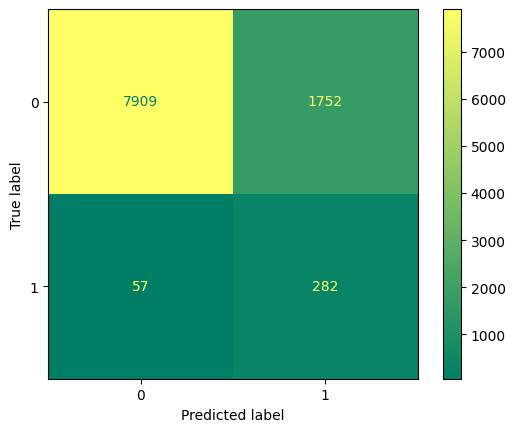

In [27]:
#CRIANDO MATRIZ DE CONFUSÃO
Y_predict = best_net.predict(scaled_X, verbose = 0)
Y_predict_array = np.empty(len(Y_predict), dtype = int)
for i in range(0, len(Y_predict)):
    if Y_predict[i] >= 0.5:
        Y_predict_array[i] = 1
    else:
        Y_predict_array[i] = 0

Y_list = Y.tolist()
Y_predict_list = Y_predict_array.tolist()
      
cm = confusion_matrix(Y_list, Y_predict_list, labels=[0,1])
disp = ConfusionMatrixDisplay(cm, display_labels=[0,1])
print('{} -> QTD DE NEURONIOS: {} / FUNÇÃO DE ATIVAÇÃO'.format(best_net_name, best_neurons))
disp.plot(cmap = 'summer')

In [38]:
#SETANDO NOVOS HIPERPARÂMETROS SE NECESSÁRIO
my_patience = 300
max_epoch = 50*my_patience
adam_initial_lr = 0.001
optimizer = {'adam': tf.keras.optimizers.Adam(learning_rate=adam_initial_lr)}

In [43]:
from random import *
seed()
#REDE COM 3 HIDDEN

#INICIANDO O TREINAMENTO
best_net_name = None
best_net = None
best_metric = 0.0
best_metric_val = 0.0
lower_bound = 0.0
result_list = []
neurons_list = []
neurons_list_2 = []
print('Começando...')

for n_neuron in np.arange(1, max_hidden_n+1):
    ix_fold = 1
    neurons_list.append(n_neuron)
    for train_index, test_index in sk_folds.split(scaled_X, Y):
        X_train, X_test = scaled_X[train_index], scaled_X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]

        sm = SMOTE()
        X_bal, Y_bal = sm.fit_resample(X_train, Y_train)

        for activations in hidden_neurons_act:
            for n_hidden_neuron in range(1,len(neurons_list)+1):
                
                random_act_1 = randint(0,3)
                random_act_2 = randint(0,3)
                inputs = keras.Input(shape=(len(my_vars), ))
                hidden_1 = keras.layers.Dense(n_neuron, activation = activations, name = 'Dense_1')(inputs)
                hidden_2 = keras.layers.Dense(n_hidden_neuron, activation = hidden_neurons_act[random_act_1], name = 'Dense_2')(hidden_1)
                hidden_3 = keras.layers.Dense(n_hidden_neuron, activation = hidden_neurons_act[random_act_2], name = 'Dense_3')(hidden_2)
                output = keras.layers.Dense(1, activation = 'sigmoid')(hidden_3)
                model_name = project_name
                PdM = keras.Model(inputs = inputs, outputs = output, name = model_name)

                metric_name = my_metric.lower()
                val_metric_name = 'val_{}'.format(metric_name)
                PdM.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=adam_initial_lr), loss='binary_crossentropy', metrics=[my_metric])
                es_loss = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = my_patience, restore_best_weights=True)
                es_metric = tf.keras.callbacks.EarlyStopping(monitor = metric_name, mode='max', patience = my_patience, min_delta = min_improvement)
                es_val_metric = tf.keras.callbacks.EarlyStopping(monitor = val_metric_name, mode='max', patience = n_k_folds*my_patience, min_delta = min_improvement)

                class_weight_for_0 = Y_train.shape[0]/(Y_train==0).sum()
                class_weight_for_1 = my_class_weight = Y_train.shape[0]/Y_train.sum()
                class_weights = {0: class_weight_for_0, 1:class_weight_for_1}
                history = PdM.fit(X_train, Y_train, validation_data=(X_test, Y_test), batch_size= X_train.shape[0], epochs=max_epoch, verbose=0, callbacks=[es_loss, es_metric, es_val_metric], class_weight = class_weights)

                model_loss = history.history['loss'][-1]
                model_val_loss = history.history['val_loss'][-1]
                metric_val = history.history[metric_name][-1]
                val_metric_val = history.history[val_metric_name][-1]
                n_epochs = len(history.history['val_loss'])

                best_net_txt=''
                is_best = False
                max_metrics = (val_metric_val > 0.98) | (metric_val == 1.0)
                if max_metrics:
                    print('REDE OVERFITADA -> DESCONSIDERADA')
                else:
                    if((metric_val > best_metric + min_improvement) & (val_metric_val >= best_metric_val)) | ((metric_val >= best_metric) & (val_metric_val > best_metric_val + min_improvement)):
                        best_net_name = model_name
                        best_metric = metric_val
                        best_metric_val = val_metric_val
                        best_net = PdM
                        best_neurons = n_neuron
                        best_activation = activations
                        best_net_txt = '***SUCESSO***'
                        is_best = True
                        print('FOLD: {}/{} - NEURONIO {}/{}'.format(ix_fold, n_k_folds, n_neuron, max_hidden_n))
                        print('{} - 1º({}{})2º({}{})3º({}{}) -> EPOCHS:{}, {}:{:.2f}%, {}:{:.2f}% {}'.format(model_name, n_neuron, activations, n_hidden_neuron, hidden_neurons_act[random_act_1], n_hidden_neuron, hidden_neurons_act[random_act_2], n_epochs, metric_name, 100.0*metric_val, val_metric_name,100.0*val_metric_val, best_net_txt))

                result_dict = {'model_name': model_name, 'optimizer': 'Adam', 'neurons': n_neuron, 'fold': ix_fold, 'loss': model_loss, 
                'val_loss': model_val_loss, metric_name: metric_val, val_metric_name: val_metric_val, 'epochs': n_epochs, 'is_best': is_best, 'net': PdM, 'activation': activations}

                result_list.append(result_dict)
                    
        ix_fold += 1
        
      
    nao_precisa_mais_neuronios = False
    if n_neuron > 1:
        if best_neurons < n_neuron:
            nao_precisa_mais_neuronios = True
            print('Rede com {} nao aumentaram a {}'.format(n_neuron, metric_name))
            break
    
    df_results = pd.DataFrame(result_list)
    df_results.drop(df_results.index[df_results[val_metric_name] == df_results[df_results.neurons == n_neuron][val_metric_name].min()], inplace=True)
    pior_resultado = df_results[df_results.neurons == n_neuron][val_metric_name].min()

    pior_resultado_nao_melhora = False
    if n_neuron > 1:
        neuron_gain = 0.0
        if pior_resultado > lower_bound:
            if lower_bound > 0.0:
                neuron_gain = pior_resultado / lower_bound - 1.0
                if neuron_gain < min_gain_neuron:
                    print('REDES COM {} NEURONIOS NÃO MELHORARAM MAIS QUE O MENOR INDICE {} {:.1f} GANHO DO NEURONIO {:.1f} / MIN {:.1f}'.format(n_neuron, val_metric_name, 100.0*pior_resultado, 100.0*neuron_gain))
                    pior_resultado_nao_melhora = True
                    break
                else:
                    print ('GANHO DA REDE COM {} NEURONIOS: {:.1f} >> {:.1f} = {:.2f}'.format(n_neuron, 100.0*lower_bound, 100.0*pior_resultado, 100.0*neuron_gain))
            else:
                print('REDE COM GANHOS DE 0.0 >> {:.1f}'.format(100.0*pior_resultado))
        else:
            print('SEM GANHO COM {} NEURONIOS PARA {}: {:.1f} >> {:.1f}'.format(n_neuron, 'Adam', 100.0*lower_bound, 100.0*pior_resultado))
            pior_resultado_nao_melhora = True
            break
    else:
        print('GANHO MINIMO ESTIMADO PARA {} NEURONIOS: {:.1f}%'.format(n_neuron+1, 100.0*pior_resultado))

    lower_bound = pior_resultado
    print('')
    if max_metrics or nao_precisa_mais_neuronios:
        break


Começando...
FOLD: 1/5 - NEURONIO 1/10
Predictive_Maintenance - 1º(1tanh)2º(1linear)3º(1linear) -> EPOCHS:747, recall:81.99%, val_recall:71.64% ***SUCESSO***
FOLD: 1/5 - NEURONIO 1/10
Predictive_Maintenance - 1º(1linear)2º(1linear)3º(1tanh) -> EPOCHS:1210, recall:82.72%, val_recall:77.61% ***SUCESSO***
FOLD: 2/5 - NEURONIO 1/10
Predictive_Maintenance - 1º(1relu)2º(1selu)3º(1tanh) -> EPOCHS:301, recall:85.98%, val_recall:83.82% ***SUCESSO***
REDE OVERFITADA -> DESCONSIDERADA
REDE OVERFITADA -> DESCONSIDERADA
GANHO MINIMO ESTIMADO PARA 2 NEURONIOS: 41.2%

FOLD: 2/5 - NEURONIO 2/10
Predictive_Maintenance - 1º(2linear)2º(2selu)3º(2linear) -> EPOCHS:892, recall:87.82%, val_recall:88.24% ***SUCESSO***
REDE OVERFITADA -> DESCONSIDERADA
GANHO DA REDE COM 2 NEURONIOS: 41.2 >> 48.5 = 17.86

REDE OVERFITADA -> DESCONSIDERADA
FOLD: 3/5 - NEURONIO 3/10
Predictive_Maintenance - 1º(3selu)2º(2selu)3º(2linear) -> EPOCHS:1215, recall:91.88%, val_recall:97.06% ***SUCESSO***
SEM GANHO COM 3 NEURONIOS PARA

In [54]:
if pior_resultado_nao_melhora or nao_precisa_mais_neuronios:
    best_row = df_results[(df_results.neurons == 3) & df_results.is_best].tail(1)
    best_net_name = best_row['model_name'].values[0]
    best_optimizer = best_row['optimizer'].values[0]
    best_net = best_row['net'].values[0]
    best_neurons = best_row['neurons'].values[0]
    best_metric = best_row[metric_name].values[0]
    best_metric_val = best_row[val_metric_name].values[0]
    best_loss = best_row['loss']
    best_val_loss = best_row['val_loss']
    best_epochs = best_row['epochs']
    best_activation = best_row['activation'].values[0]

Predictive_Maintenance -> QTD DE NEURONIOS: 3 / FUNÇÃO DE ATIVAÇÃO


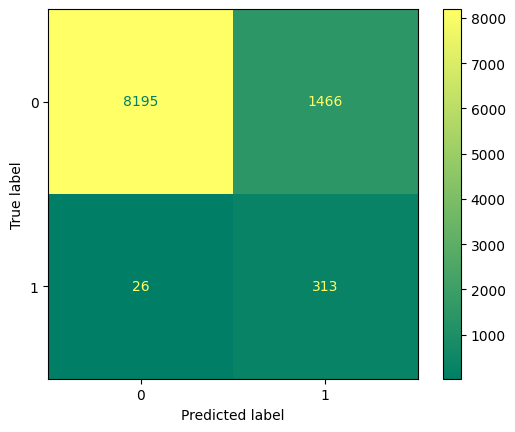

In [55]:
#CRIANDO MATRIZ DE CONFUSÃO
Y_predict = best_net.predict(scaled_X, verbose = 0)
Y_predict_array = np.empty(len(Y_predict), dtype = int)
for i in range(0, len(Y_predict)):
    if Y_predict[i] >= 0.5:
        Y_predict_array[i] = 1
    else:
        Y_predict_array[i] = 0

Y_list = Y.tolist()
Y_predict_list = Y_predict_array.tolist()
      
cm = confusion_matrix(Y_list, Y_predict_list, labels=[0,1])
disp = ConfusionMatrixDisplay(cm, display_labels=[0,1])
print('{} -> QTD DE NEURONIOS: {} / FUNÇÃO DE ATIVAÇÃO'.format(best_net_name, best_neurons))
disp.plot(cmap = 'summer')

In [61]:
baseline_model = best_row_baseline
best_model = best_row

In [63]:
baseline_model.head()


,model_name,optimizer,neurons,fold,loss,val_loss,recall,val_recall,epochs,is_best,net,activation
10,Predictive_Maintenance,Adam,1,3,0.900312,0.867289,0.859779,0.985294,301,True,<keras.engine.functional.Functional object at ...,relu


In [64]:
best_model.head()

,model_name,optimizer,neurons,fold,loss,val_loss,recall,val_recall,epochs,is_best,net,activation
94,Predictive_Maintenance,Adam,3,3,0.469832,0.713879,0.918819,0.970588,1215,True,<keras.engine.functional.Functional object at ...,selu


In [65]:
frames = [baseline_model, best_model]
df_final = pd.concat(frames)
df_final.head()

,model_name,optimizer,neurons,fold,loss,val_loss,recall,val_recall,epochs,is_best,net,activation
10,Predictive_Maintenance,Adam,1,3,0.900312,0.867289,0.859779,0.985294,301,True,<keras.engine.functional.Functional object at ...,relu
94,Predictive_Maintenance,Adam,3,3,0.469832,0.713879,0.918819,0.970588,1215,True,<keras.engine.functional.Functional object at ...,selu


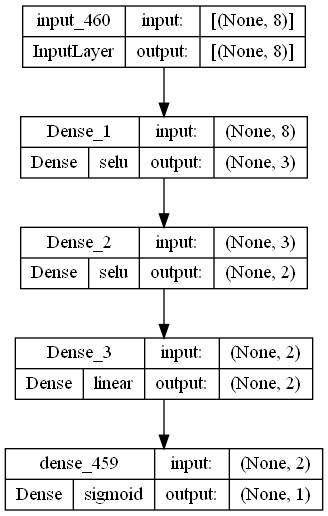

In [70]:
tf.keras.utils.plot_model(df_final['net'].tail(1).values[0], to_file='Best_Net_Topology.png', 
                            show_shapes=True, show_dtype=False, show_layer_names=True, show_layer_activations=True)

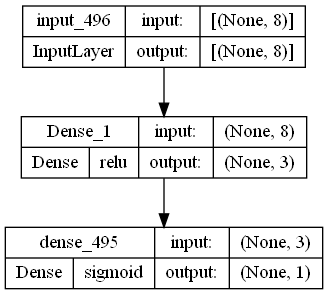

In [71]:
tf.keras.utils.plot_model(df_final['net'].head(1).values[0], to_file='Baseline_Net_Topology.png', 
                            show_shapes=True, show_dtype=False, show_layer_names=True, show_layer_activations=True)